In [1]:
import os
import sys
import torch 
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision('high')

import mlflow.pytorch

import pytorch_lightning as pl
from lightning.pytorch.loggers import MLFlowLogger

In [2]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [10]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
IS_HOUR = False
RANDOM_STATE = 1
PAST_WINDOW = 7
if IS_HOUR:
    PAST_WINDOW *= 24
FUTURE_WINDOW = 30
if IS_HOUR:
    FUTURE_WINDOW *= 24
BATCH_SIZE = 2048*16
ROLLING_WINDOW = 30
if IS_HOUR:
    ROLLING_WINDOW *= 24


DATE_COLUMNS = ['year','month','day','hour'] if IS_HOUR else ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]
MODEL_INPUT_FEATURES = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']




def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [11]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # cal roll mean
    regions_df[region] = regions_df[region].rolling(ROLLING_WINDOW).mean().dropna()

    # # create diff
    # regions_df[region] = regions_df[region].diff(1).dropna()

    #standardise
    regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    
    # add week info
    regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    regions_df[region]['month'] = regions_df[region].index.to_series().dt.month

del region

In [12]:
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W,week,month
date,,,,,,,,,,,,,,,,,
2013-03-30,1.059640,1.119624,2.199485,1.077619,0.337859,-0.227146,-0.737353,0.087692,-0.754998,-0.444168,0.824808,0.374224,0.088488,-0.658791,-0.188763,13,3
2013-03-31,1.291442,1.330665,2.206880,1.192947,0.389990,-0.290945,-0.723996,0.036462,-0.698095,-0.444168,0.670748,0.236047,0.233359,-0.593950,-0.241531,13,3
2013-04-01,1.380441,1.411857,2.157440,1.129430,0.412095,-0.268631,-0.692544,-0.019935,-0.667928,-0.444168,0.810206,0.298854,0.193849,-0.626370,-0.276710,14,4
2013-04-02,1.411879,1.434890,2.103458,1.101702,0.395292,-0.232777,-0.678256,-0.031851,-0.638913,-0.444168,0.832840,0.085308,0.430911,-0.788473,-0.065638,14,4
2013-04-03,1.552602,1.619156,2.173775,1.196494,0.444838,-0.240899,-0.672010,-0.072423,-0.607506,-0.444168,0.782460,-0.040307,0.523102,-0.739842,0.004719,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,0.186848,-0.288377,0.633840,-0.112421,0.112864,0.081990,-1.199821,1.265120,-1.466992,-0.670240,1.032386,1.126639,-0.738631,-0.362355,0.429375,8,2
2017-02-25,-0.030044,-0.470052,0.579647,-0.181887,-0.021957,0.085527,-1.178478,1.259848,-1.469003,-0.670240,0.982736,1.076393,-0.712290,-0.670349,0.728393,8,2
2017-02-26,-0.072000,-0.510791,0.547744,-0.099852,-0.016670,0.054785,-1.157139,1.239685,-1.451267,-0.673659,0.917902,1.170707,-0.820346,-0.613110,0.635888,8,2


In [13]:
import copy
feature = "PM2.5"
feature_df = regions_df[Region.AOTIZHONGXIN][[feature]]
window = PAST_WINDOW+FUTURE_WINDOW
shift = window
dfs = []
for i in range(shift):
    dfs.append((feature_df[feature].shift(i+1)))

feature_df = pd.concat(dfs, axis=1).dropna()

feature_df.columns=[f"shift_{shift-index-1}" for index in range(shift)]
feature_df

,shift_36,shift_35,shift_34,shift_33,shift_32,shift_31,shift_30,shift_29,shift_28,shift_27,...,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
date,,,,,,,,,,,,,,,,,,,,,
2013-05-06,-0.737341,-0.935335,-0.984284,-0.930192,-0.904174,-0.821243,-0.604236,-0.514197,-0.492121,-0.542284,...,0.607248,0.657469,0.854711,1.204754,1.438579,1.552602,1.411879,1.380441,1.291442,1.059640
2013-05-07,-0.445552,-0.737341,-0.935335,-0.984284,-0.930192,-0.904174,-0.821243,-0.604236,-0.514197,-0.492121,...,0.576040,0.607248,0.657469,0.854711,1.204754,1.438579,1.552602,1.411879,1.380441,1.291442
2013-05-08,-0.307661,-0.445552,-0.737341,-0.935335,-0.984284,-0.930192,-0.904174,-0.821243,-0.604236,-0.514197,...,0.422026,0.576040,0.607248,0.657469,0.854711,1.204754,1.438579,1.552602,1.411879,1.380441
2013-05-09,-0.163125,-0.307661,-0.445552,-0.737341,-0.935335,-0.984284,-0.930192,-0.904174,-0.821243,-0.604236,...,0.283500,0.422026,0.576040,0.607248,0.657469,0.854711,1.204754,1.438579,1.552602,1.411879
2013-05-10,-0.107356,-0.163125,-0.307661,-0.445552,-0.737341,-0.935335,-0.984284,-0.930192,-0.904174,-0.821243,...,0.335917,0.283500,0.422026,0.576040,0.607248,0.657469,0.854711,1.204754,1.438579,1.552602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,0.403712,0.501669,0.435440,0.381109,0.403357,0.281648,0.234375,0.261826,0.298581,0.119543,...,1.586903,1.595340,1.411179,1.234942,1.334113,1.469865,1.477840,1.534592,2.019231,2.418108
2017-02-25,0.186848,0.403712,0.501669,0.435440,0.381109,0.403357,0.281648,0.234375,0.261826,0.298581,...,2.036405,1.586903,1.595340,1.411179,1.234942,1.334113,1.469865,1.477840,1.534592,2.019231
2017-02-26,-0.030044,0.186848,0.403712,0.501669,0.435440,0.381109,0.403357,0.281648,0.234375,0.261826,...,1.815642,2.036405,1.586903,1.595340,1.411179,1.234942,1.334113,1.469865,1.477840,1.534592


In [14]:
feature_df.corr().style.background_gradient(cmap='coolwarm')

,shift_36,shift_35,shift_34,shift_33,shift_32,shift_31,shift_30,shift_29,shift_28,shift_27,shift_26,shift_25,shift_24,shift_23,shift_22,shift_21,shift_20,shift_19,shift_18,shift_17,shift_16,shift_15,shift_14,shift_13,shift_12,shift_11,shift_10,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
shift_36,1.000000,0.991469,0.974056,0.954011,0.933134,0.912187,0.891662,0.871695,0.851929,0.832371,0.812677,0.792160,0.770655,0.748375,0.724999,0.700962,0.676708,0.652453,0.628387,0.604570,0.581073,0.557477,0.533156,0.508042,0.482325,0.455274,0.427255,0.398901,0.370247,0.341897,0.316685,0.299156,0.285641,0.273755,0.262294,0.250616,0.238572
shift_35,0.991469,1.000000,0.991538,0.974148,0.954201,0.933446,0.912527,0.891936,0.871933,0.852204,0.832569,0.812749,0.792240,0.770867,0.748571,0.725150,0.701055,0.676778,0.652515,0.628456,0.604489,0.580846,0.557055,0.532761,0.507790,0.481947,0.454902,0.427015,0.398739,0.370276,0.341885,0.316611,0.298628,0.285257,0.273281,0.261799,0.250384
shift_34,0.974056,0.991538,1.000000,0.991543,0.974185,0.954296,0.933537,0.912572,0.891963,0.871993,0.852225,0.832473,0.812655,0.792275,0.770946,0.748665,0.725215,0.701139,0.676854,0.652582,0.628360,0.604244,0.580423,0.556598,0.532374,0.507292,0.481366,0.454370,0.426505,0.398261,0.369638,0.341114,0.315504,0.297672,0.284269,0.272328,0.261091
shift_33,0.954011,0.974148,0.991543,1.000000,0.991564,0.974260,0.954374,0.933574,0.912593,0.892014,0.872010,0.852135,0.832385,0.812684,0.792344,0.771032,0.748729,0.725301,0.701216,0.676922,0.652499,0.628137,0.603854,0.579993,0.556229,0.531898,0.506729,0.480846,0.453870,0.426036,0.397639,0.368886,0.340025,0.314565,0.296702,0.283335,0.271630
shift_32,0.933134,0.954201,0.974185,0.991564,1.000000,0.991582,0.974272,0.954355,0.933547,0.912590,0.891996,0.871898,0.852021,0.832375,0.812736,0.792439,0.771123,0.748859,0.725423,0.701320,0.676879,0.652320,0.627807,0.603453,0.579611,0.555750,0.531290,0.506122,0.480229,0.453213,0.425178,0.396622,0.367584,0.338872,0.313407,0.295605,0.282458
shift_31,0.912187,0.933446,0.954296,0.974260,0.991582,1.000000,0.991571,0.974243,0.954326,0.933534,0.912580,0.891913,0.871807,0.852013,0.832443,0.812870,0.792588,0.771329,0.749057,0.725592,0.701357,0.676793,0.652107,0.627492,0.603112,0.579188,0.555160,0.530658,0.505452,0.479454,0.452200,0.423986,0.395199,0.366302,0.337605,0.312220,0.294612
shift_30,0.891662,0.912527,0.933537,0.954374,0.974272,0.991571,1.000000,0.991570,0.974246,0.954332,0.933553,0.912566,0.891889,0.871825,0.852088,0.832587,0.813051,0.792833,0.771568,0.749265,0.725713,0.701389,0.676736,0.651938,0.627268,0.602826,0.578735,0.554649,0.530101,0.504788,0.478581,0.451168,0.422748,0.394080,0.365197,0.336574,0.311343
shift_29,0.871695,0.891936,0.912572,0.933574,0.954355,0.974243,0.991570,1.000000,0.991571,0.974247,0.954343,0.933546,0.912551,0.891902,0.871874,0.852193,0.832732,0.813254,0.793033,0.771741,0.749374,0.725748,0.701347,0.676593,0.651748,0.627022,0.602437,0.578304,0.554187,0.529578,0.504100,0.477762,0.450111,0.421806,0.393136,0.364310,0.335838
shift_28,0.851929,0.871933,0.891963,0.912593,0.933547,0.954326,0.974246,0.991571,1.000000,0.991571,0.974253,0.954333,0.933530,0.912560,0.891936,0.871956,0.852315,0.832907,0.813427,0.793182,0.771834,0.749397,0.725695,0.701199,0.676409,0.651507,0.626650,0.602038,0.577885,0.553738,0.528991,0.503397,0.476788,0.449254,0.420936,0.392313,0.363646
shift_27,0.832371,0.852204,0.871993,0.892014,0.912590,0.933534,0.954332,0.974247,0.991571,1.000000,0.991577,0.974236,0.954310,0.933538,0.912600,0.892028,0.872087,0.852502,0.833092,0.813586,0.793275,0.771849,0.749328,0.725526,0.700993,0.676140,0.651098,0.626211,0.601576,0.577387,0.553088,0.528215,0.502337,0.475855,0.448307,0.420040,0.391591


In [15]:

feature = "PM2.5"
x_df = regions_df[Region.AOTIZHONGXIN][MODEL_INPUT_FEATURES].shift(FUTURE_WINDOW)
y_df = regions_df[Region.AOTIZHONGXIN][[feature]]
dataset_df = pd.concat([y_df,x_df],axis=1).dropna()
dataset_df.columns = ['target'] + MODEL_INPUT_FEATURES
print(dataset_df.head())
dataset_df.corr().style.background_gradient(cmap='coolwarm')

              target     PM2.5      PM10       SO2       NO2        CO   
date                                                                     
2013-04-29 -0.604236  1.059640  1.119624  2.199485  1.077619  0.337859  \
2013-04-30 -0.821243  1.291442  1.330665  2.206880  1.192947  0.389990   
2013-05-01 -0.904174  1.380441  1.411857  2.157440  1.129430  0.412095   
2013-05-02 -0.930192  1.411879  1.434890  2.103458  1.101702  0.395292   
2013-05-03 -0.984284  1.552602  1.619156  2.173775  1.196494  0.444838   

                  O3      TEMP      PRES      DEWP      RAIN      WSPM  
date                                                                    
2013-04-29 -0.227146 -0.737353  0.087692 -0.754998 -0.444168  0.824808  
2013-04-30 -0.290945 -0.723996  0.036462 -0.698095 -0.444168  0.670748  
2013-05-01 -0.268631 -0.692544 -0.019935 -0.667928 -0.444168  0.810206  
2013-05-02 -0.232777 -0.678256 -0.031851 -0.638913 -0.444168  0.832840  
2013-05-03 -0.240899 -0.672010 -0.072423 -0

,target,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
target,1.000000,0.308796,0.203003,0.284367,0.459468,0.392380,-0.590936,-0.424029,0.467844,-0.311458,-0.366469,-0.191026
PM2.5,0.308796,1.000000,0.805588,0.432688,0.791898,0.778857,-0.595309,-0.541315,0.524005,-0.404522,-0.350588,-0.191946
PM10,0.203003,0.805588,1.000000,0.506061,0.681742,0.546272,-0.526196,-0.518350,0.465962,-0.505107,-0.517424,0.099931
SO2,0.284367,0.432688,0.506061,1.000000,0.324680,0.509663,-0.570296,-0.700229,0.547359,-0.712518,-0.526982,0.212499
NO2,0.459468,0.791898,0.681742,0.324680,1.000000,0.699162,-0.739381,-0.510637,0.538138,-0.330950,-0.364354,-0.397664
CO,0.392380,0.778857,0.546272,0.509663,0.699162,1.000000,-0.717262,-0.809102,0.785572,-0.676933,-0.455300,0.026678
O3,-0.590936,-0.595309,-0.526196,-0.570296,-0.739381,-0.717262,1.000000,0.835263,-0.856704,0.707984,0.604859,0.141799
TEMP,-0.424029,-0.541315,-0.518350,-0.700229,-0.510637,-0.809102,0.835263,1.000000,-0.952739,0.960371,0.676270,-0.292379
PRES,0.467844,0.524005,0.465962,0.547359,0.538138,0.785572,-0.856704,-0.952739,1.000000,-0.890181,-0.664285,0.218790
DEWP,-0.311458,-0.404522,-0.505107,-0.712518,-0.330950,-0.676933,0.707984,0.960371,-0.890181,1.000000,0.723275,-0.492249


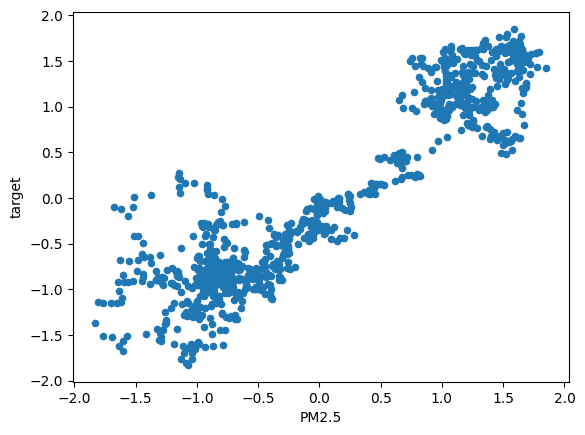

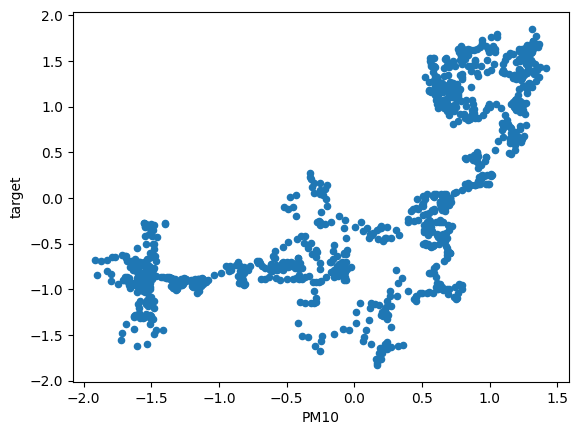

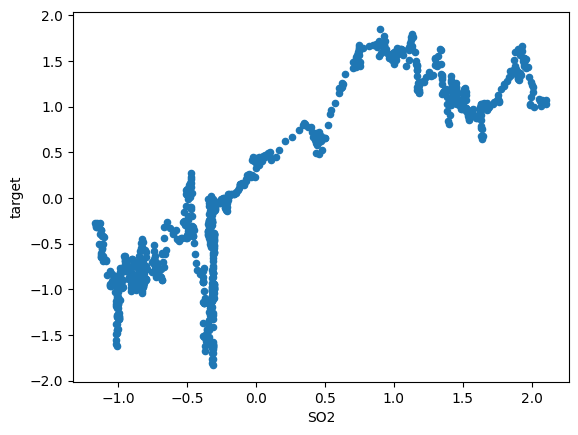

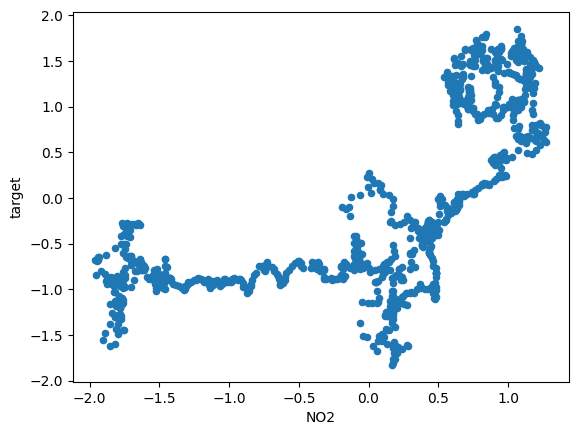

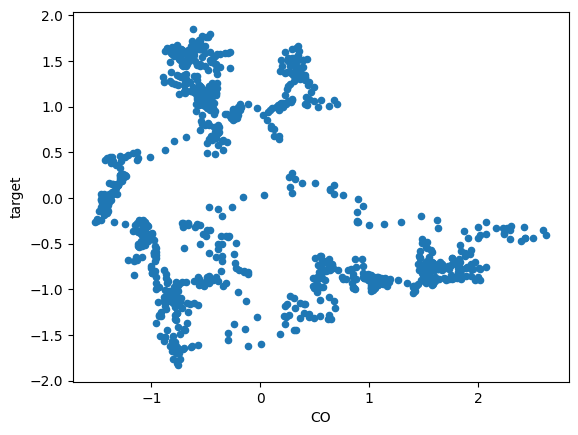

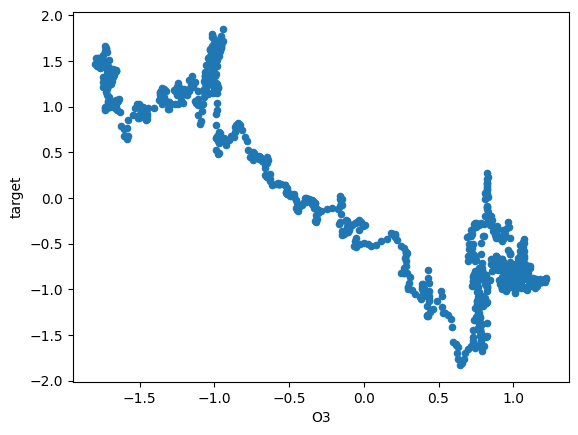

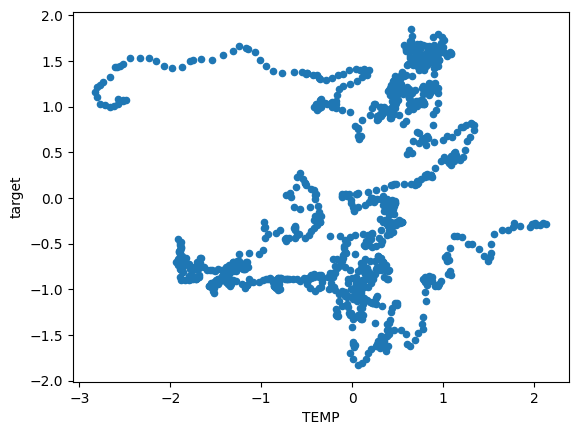

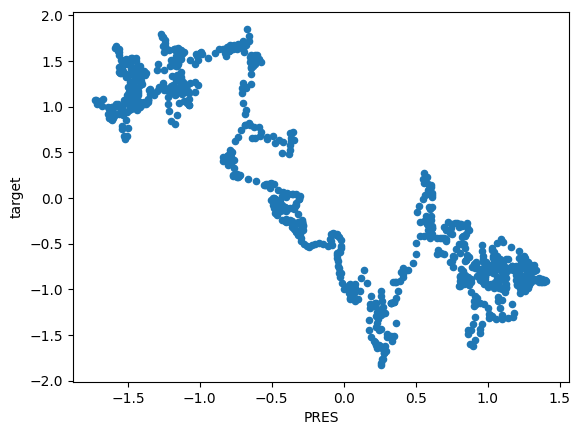

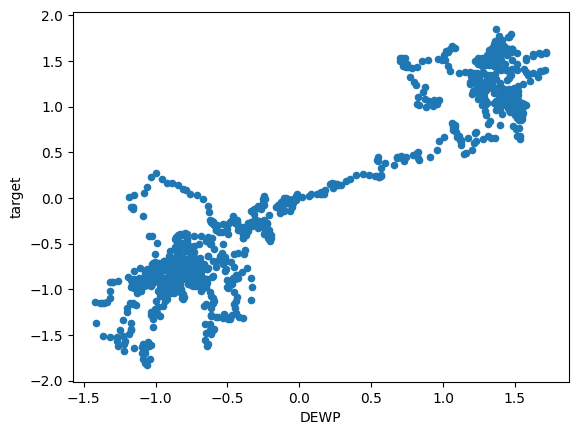

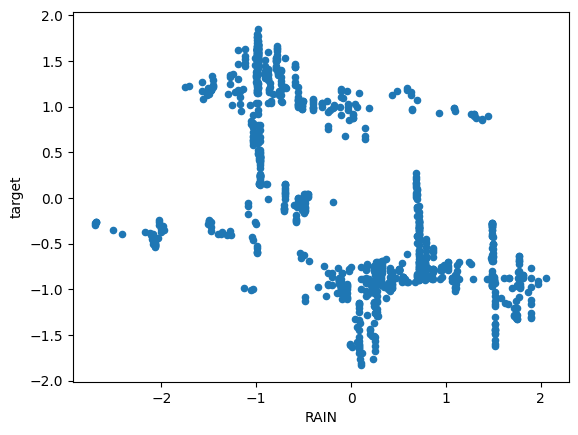

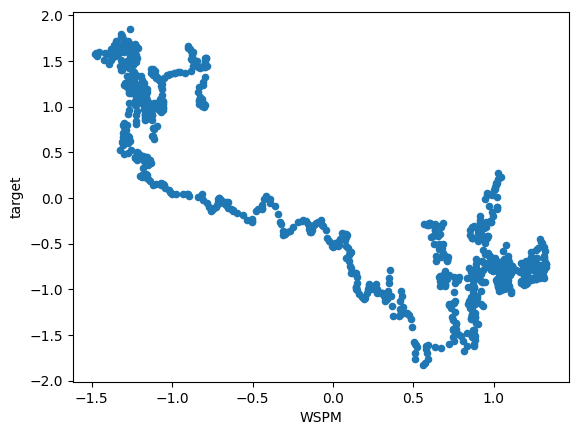

In [40]:
for feature in MODEL_INPUT_FEATURES:
    dataset_df[['target',feature]].plot(
        kind='scatter',
        y='target',
        x=feature)

In [41]:
from torch import Tensor
from numpy import concatenate, clip
from torch.utils.data import Dataset
from numpy.lib.stride_tricks import sliding_window_view

class FeatureForcastingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, pred_feature:str, past_window:int, future:int, future_window:int, model_features:list=MODEL_INPUT_FEATURES, split_date:str='2015-03-01 00:00:00', is_train:bool=True):  
        # self.pred_feature = pred_feature
        # self.model_features = model_features
        # self.past_window = past_window
        # self.future_window = future_window

        # split to train and test 
        df = df[df.index < split_date] if is_train else df[df.index >= split_date] 
        
        # # normalize
        # norm_feature_df = df[self.model_features] 
        # self.mean = norm_feature_df.mean()
        # self.std = norm_feature_df.std()
        # norm_feature_df = ( norm_feature_df - self.mean ) / self.std
        
        # # build sliding window for features
        # cols = [f"{feature}_{index}" for feature in self.model_features for index in range(self.past_window)]
        features = df[model_features].to_numpy()
        
        # # build 1-hot encoding for month 
        # month_col = [f"month_{index}" for index in range(1,13)]
        # month_df = clip(sliding_window_view(df[month_col], window_shape=dataset_window, axis=0)[:,:,:-future_window].sum(axis=2),None,1)
        
        # build targets
        target = df[['target']].to_numpy()

        # build datset
        # features = concatenate([features,month_df],axis=1)
        self.features = Tensor(features)
        self.targets = Tensor(target)
        # discard variables
        del df

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    
datset = FeatureForcastingDataset(dataset_df,MODEL_INPUT_FEATURES[0],PAST_WINDOW,1, FUTURE_WINDOW,is_train=True)
datset[1]

(tensor([ 1.2800,  0.7870,  2.0629,  1.0493,  0.4916, -1.6451, -2.5245, -1.6967,
          0.9003, -0.5545, -0.8315]),
 tensor([1.0642]))

In [42]:
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from sklearn.metrics import r2_score
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError

class FeatureForecastingModel(pl.LightningModule):
    def __init__(self, model_features:list=MODEL_INPUT_FEATURES, past_window:int=1, future_window:int=1, hidden_layer_size:int=2048, hidden_layers:int=3):
        super(FeatureForecastingModel, self).__init__()
        
        # init model features
        self.past_window = past_window
        self.future_window = future_window
        self.hidden_layers = hidden_layers
        self.hidden_layer_size = hidden_layer_size

        layer_list = []

        # building input layer
        layer_list.append(nn.Linear(in_features=(len(model_features)), out_features=self.hidden_layer_size))
        layer_list.append(nn.LeakyReLU(0.1))
        # building hidden layers
        for h_layer in range(self.hidden_layers):
            layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=self.hidden_layer_size))
            layer_list.append(nn.LeakyReLU(0.1))
        # building ouput layer
        layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=1))

        # build model
        self.layers = nn.Sequential(*layer_list)
        
        # metics
        self.r2_score = R2Score()
        self.mae = MeanAbsoluteError()
        self.rmse = MeanSquaredError(squared=False)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # Flatten the input images
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.r2_score(y_hat, y)
        self.log('r2_score', self.r2_score, on_epoch=True)
        self.mae(y_hat, y)
        self.log('mae', self.mae, on_epoch=True)
        self.rmse(y_hat, y)
        self.log('rmse', self.rmse, on_epoch=True)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.001)


In [31]:
from torch.utils.data import DataLoader 
import torch 
torch.set_float32_matmul_precision('medium')

import mlflow

# Auto log all MLflow entities
mlflow.pytorch.autolog()
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("AQL-MM")

# Build Bataset
train_dataset = FeatureForcastingDataset(dataset_df,feature, future=1, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=True)
val_dataset = FeatureForcastingDataset(dataset_df,feature,future=1, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)

# build model
model = FeatureForecastingModel(past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, hidden_layer_size=2048, hidden_layers=3)

# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu", 
    logger=False,
    enable_progress_bar=True,
    enable_checkpointing=False,
    devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
)

# log model into mlflow
with mlflow.start_run():
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.validate(model, val_loader)

2023/06/10 03:01:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023/06/10 03:01:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/mutakabbir/Projects/federated-airquality-modeling/.venv/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:352: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.0.5 and 2.0.1.post0 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 12.6 M
1 | r2_score | R2Score         

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]                     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

2023/06/10 03:02:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


2023/06/10 03:02:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │            nan            │
│         r2_score          │            nan            │
│           rmse            │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘